<a href="https://colab.research.google.com/github/shaking54/CS114.K21.KHTN/blob/master/Final_projectCS114_K21_KHTN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Đề tài: Phân loại các tòa nhà trong UIT thông qua ảnh **




#I. Mô tả bài toán
  
  Input: Một bức ảnh tòa nhà trong UIT

  Ouput: Đó là tòa nhà nào trong UIT

In [1]:
import zipfile
with zipfile.ZipFile("/content/drive/My Drive/dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [2]:
import tensorflow as tf
import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
tf.__version__

Using TensorFlow backend.


'2.2.0'

#II. Mô tả bộ dữ liệu 

  - Dataset tự thu thập cùng với 2 bạn Nguyễn Khánh Toàn và Võ Quốc An

  - Tiền xử lý dữ liệu: resize bộ dữ liệu, cắt ảnh, tăng cường dữ liệu

  

##* Load ảnh, xử lý kích thước ảnh

In [3]:
def load_images_from_folder(pathdir):
    images = []
    labels = []
    for folder in os.listdir(pathdir):
      for filename in os.listdir(pathdir+'/'+folder):
          if filename.endswith('.jpg') or filename.endswith('.JPG') :
            img = cv2.imread(pathdir+'/'+folder+'/'+filename, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (224,224))
            #img = image.img_to_array(img)
            #img=img/255
            images.append(img)
            labels.append(folder)
    return images, labels


In [4]:
X, y = load_images_from_folder('/content/dataset')

#III. Mô tả đặc trưng 

- Trong xử lý ảnh, mỗi pixel sẽ là một đặc trưng của dữ liệu. Bộ dataset là ảnh của những tòa nhà trong UIT. Đối với bộ dataset này thì em sử dụng HOG( histogram of oriented gradients) để trích xuât vector đặc trưng của ảnh.
- Đối với dataset là những tòa nhà thì các vector đặc trưng nhận được vô cùng hữu ích vì nó sẽ trích xuất được các edge features. Đó là sự khác biệt lớn giữa hai pixel lân cận. Khi trích xuất được những đặc trưng này thì model sẽ hoạt động hiệu quả.

##*rút trích đặc trưng

In [5]:
from skimage.feature import hog

def feature_extraction(img):
    features = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True)
    features=features.ravel()
    return features


In [6]:
def exposure_hog(img):
    ft, hog_img = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True, visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))
    features = image.img_to_array(hog_image_rescaled)
    return features

In [7]:
def get_feature(data):
    features = []
    for image in data:
        f = feature_extraction(image)
        #f=f/255
        features.append(f)
    return features
    

In [8]:
def exposure_features(data):
    features = []
    for image in data:
      f = exposure_hog(image)
      features.append(f)
    return features

In [9]:
X_features = get_feature(X)

In [10]:
X_features = np.asarray(X_features)
y = np.asarray(y)

In [11]:
X_features.shape

(811, 26244)

C


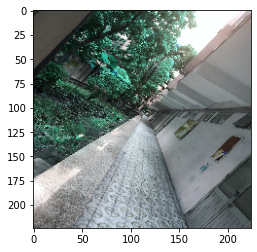

In [12]:
plt.imshow(X[199])
print(y[199])

#** tính chiều dài của features vector:
- pixels_per_cell(x,y): ảnh được chia ra thành các ô có số pixel là x*y
- cells_per_block(x,y): mỗi block chưa x*y ô pixels
- orientations : số hướng của vector đặc trưng

giả sử chúng ta có ảnh là 68 * 128 ( w * h), orientations = 9, pixels_per_cell(8,8), cells_per_block(3,3)
 
thì với số ô pixel có được là 8 * 16

với 16 ô pixel năm ở trục tung thì ta tính được có 14 vị trí các ô block
và 6 ô vị trí ở trục hoành

với mỗi vị trí thì ta tính được là 9 * 3 * 3 = 81 vector thành phần.

-> chiều dài của features vector : 81 * 14 * 6 = 6804


In [13]:
# from skimage.feature import hog
# from skimage import data, exposure
# image = cv2.imread('/content/dataset/B/IMG_1641.JPG', cv2.IMREAD_GRAYSCALE)
# a, hog_a = feature_extraction(image)
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
# ax1.axis('off')
# ax1.imshow(image, cmap=plt.cm.gray)
# ax1.set_title('Input image')

# # Rescale histogram for better display
# hog_image_rescaled = exposure.rescale_intensity(hog_a, in_range=(0, 10))
# plt.figure(figsize=(8,4))
# ax2.axis('off')
# ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
# ax2.set_title('Histogram of Oriented Gradients')
# #plt.show()

In [14]:
# from skimage.feature import hog
# from skimage import data, exposure
# image = cv2.imread('/content/dataset/B/IMG_1641.JPG', cv2.COLOR_BGR2RGB)
# image = cv2.resize(image, (128,64))
# fd = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), multichannel=True)
# #plt.imshow(fd)
# fd = np.array(fd)

In [15]:
from sklearn.model_selection import train_test_split
(X_train, X_test, y_train, y_test) = train_test_split(X_features, y, test_size=0.35, shuffle=True)

#IV. Mô tả thuật toán máy học.

  - Sẽ sử dụng nhiều thuật toán classification khác nhau để có cái nhìn khác nhau về các thuật toán.
  Ví dụ: SVM classification, Decision Tree Classification, ...

##*Phân loại với model SVM classification

In [16]:
from sklearn.svm import SVC
SVCClassifier = SVC(C=1.8)
SVCClassifier.fit(X_train, y_train)

SVC(C=1.8, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [17]:
SVCClassifier.score(X_train, y_train)

1.0

In [18]:
SVCClassifier.score(X_test, y_test)

0.8415492957746479

In [19]:
ypred=SVCClassifier.predict(X_test)

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           B       0.90      0.89      0.90        94
           C       0.88      0.85      0.86        91
     Canteen       0.67      0.83      0.74        52
           D       0.90      0.85      0.88        41
           E       0.00      0.00      0.00         6

    accuracy                           0.84       284
   macro avg       0.67      0.68      0.68       284
weighted avg       0.83      0.84      0.84       284



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##* Linear SVC

In [70]:
from sklearn.svm import LinearSVC

Linear = LinearSVC(C=1.75, multi_class= "ovr")
Linear.fit(X_train, y_train)
LinearPred = Linear.predict(X_test)
print(classification_report(y_test, LinearPred))
#Linear.score(y_test, LinearPred)

              precision    recall  f1-score   support

           B       0.87      0.88      0.88        94
           C       0.87      0.82      0.85        91
     Canteen       0.71      0.81      0.76        52
           D       0.90      0.90      0.90        41
           E       1.00      0.50      0.67         6

    accuracy                           0.85       284
   macro avg       0.87      0.78      0.81       284
weighted avg       0.85      0.85      0.85       284



In [71]:
Linear.score(X_test, y_test)

0.8450704225352113

##* SGDClassifications

In [72]:
from sklearn.linear_model import SGDClassifier

SGD = SGDClassifier()
SGD.fit(X_train, y_train)
SGDpred = SGD.predict(X_test)
print(classification_report(y_test, SGDpred))
SGD.score(X_test, y_test)

              precision    recall  f1-score   support

           B       0.97      0.78      0.86        94
           C       0.81      0.74      0.77        91
     Canteen       0.57      0.87      0.69        52
           D       0.80      0.85      0.82        41
           E       1.00      0.50      0.67         6

    accuracy                           0.79       284
   macro avg       0.83      0.75      0.76       284
weighted avg       0.82      0.79      0.79       284



0.7852112676056338

##* Gradient boosting classification

In [73]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier()
GBC.fit(X_train, y_train)
GBCpred = SGD.predict(X_test)
print(classification_report(y_test, GBCpred))
GBC.score(X_test, y_test)

              precision    recall  f1-score   support

           B       0.97      0.78      0.86        94
           C       0.81      0.74      0.77        91
     Canteen       0.57      0.87      0.69        52
           D       0.80      0.85      0.82        41
           E       1.00      0.50      0.67         6

    accuracy                           0.79       284
   macro avg       0.83      0.75      0.76       284
weighted avg       0.82      0.79      0.79       284



0.7464788732394366

#V. Cài đặt, Tinh chỉnh tham số

In [21]:
from sklearn.svm import SVC
def turning(min_ep=1, max_ep=2):
    r = [x * 0.1 for x in range(10*min_ep, 10*max_ep)]
    mean = []
    for i in r:
        SVCClassifier = SVC(C=i)
        SVCClassifier.fit(X_train, y_train)  
        mean.append(SVCClassifier.score(X_test, y_test))
    mean = np.array(mean)
    r = np.array(r)
    return mean, r
      

In [22]:
mean, r = turning(1,3)

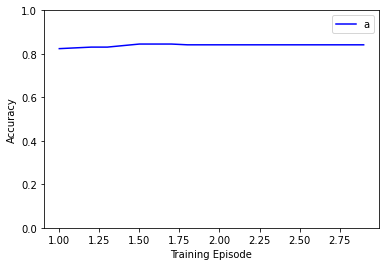

In [23]:
plt.xlabel('Training Episode')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.plot(r,mean, 'b-', label='a')
plt.legend()

##* Xử dụng model cho một bức ảnh

In [58]:
 def predict_one_image(path):
    img = cv2.imread(path, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (224,224))
    img = feature_extraction(img)
    #img = img/255
    img = img.reshape(1, img.shape[0])
    return img

In [52]:
y_test.shape

(284,)

/content/dataset/Canteen/IMG_1668.JPG
['Canteen']


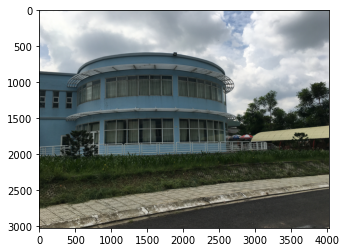

In [63]:
path = input()
img = Image.open(path)
plt.imshow(img)
print(SVCClassifier.predict(predict_one_image(path)))

#*Xử lý trích xuất features bằng HOG và tăng cường cường độ của features

In [ ]:
X_hog = exposure_featuress(X)
X_hog = np.asarray(X_hog)
X_hog.shape

In [ ]:
X_hog = X_hog.reshape(X_hog.shape[0], X_hog.shape[1]*X_hog.shape[2])

In [ ]:
from sklearn.model_selection import train_test_split
(X_train, X_test, y_train, y_test) = train_test_split(X_hog, y, test_size=0.35, shuffle=True)
SVCClassifier = SVC(C=1.8)
SVCClassifier.fit(X_train, y_train)
print(SVCClassifier.score(X_test, y_test))
ypred=SVCClassifier.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, ypred))

In [ ]:
mean, r = turning(1,3)
plt.xlabel('Training Episode')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.plot(r,mean, 'b-', label='a')
plt.legend()

VI. Đánh giá kết quả, kết luật
- Bài toán 